## Prepare data for YOLO training in .YAML format

In [63]:
import glob
import numpy as np
import re
import cv2

IMAGE_SIZE=(256, 256)

def dataloader(pathology):
    t = glob.glob('archive/Dataset_BUSI_with_GT/'+pathology+'/*')
    t_mask = glob.glob('archive/Dataset_BUSI_with_GT/'+pathology+'/*mask*')
    t = list(set(t).difference(set(t_mask)))
    t_mask = [i for i in t_mask if 'mask.png' in i]
    t = sorted(t)
    t_mask = sorted(t_mask)
    for i in range(0,133):
        num1= re.search('\(([^)]+)', t[i]).group(1)
        num2= re.search('\(([^)]+)', t_mask[i]).group(1)
        #print(num1,num2)
        assert num1 == num2
    return t,t_mask

#normal,normal_mask=dataloader('normal')
malignant,malignant_mask=dataloader('malignant')
benign,benign_mask=dataloader('benign')

#combined=np.concatenate((normal,malignant,benign))
#combined_mask=np.concatenate((normal_mask,malignant_mask,benign_mask))

combined=np.concatenate((malignant,benign))
combined_mask=np.concatenate((malignant_mask,benign_mask))

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(combined, combined_mask, test_size=0.80, random_state=42)

In [83]:
from pathlib import Path
import cv2
from imantics import Polygons, Mask

Path("datasets/Real_breast_cancer/train/images/").mkdir(parents=True, exist_ok=True)
Path("datasets/Real_breast_cancer/train/labels/").mkdir(parents=True, exist_ok=True)
Path("datasets/Real_breast_cancer/test/images/").mkdir(parents=True, exist_ok=True)
Path("datasets/Real_breast_cancer/test/labels/").mkdir(parents=True, exist_ok=True)
for index,i in enumerate(X_train):
    img=cv2.imread(i)
    img=cv2.resize(img, (256, 256))
    cv2.imwrite('datasets/Real_breast_cancer/train/images/'+str(index)+'.png',img)
for index,i in enumerate(X_test):
    img=cv2.imread(i)
    img=cv2.resize(img, (256, 256))
    cv2.imwrite('datasets/Real_breast_cancer/test/images/'+str(index)+'.png',img)

from PIL import Image
from rasterio import features
def create_label(image_path, label_path):
    img=Image.open(image_path)
    arr=img.resize((256, 256))
    arr = np.asarray(arr,dtype=np.uint8)
    #arr = np.asarray(Image.open(image_path),dtype=np.uint8)
    #print(arr.shape)
    # There may be a better way to do it, but this is what I have found so far
    cords = list(features.shapes(arr, mask=(arr >0)))[0][0]['coordinates'][0]
    label_line = '0 ' + ' '.join([f'{int(cord[0])/arr.shape[0]} {int(cord[1])/arr.shape[1]}' for cord in cords])

    label_path.parent.mkdir(parents=True, exist_ok=True )
    with label_path.open('w') as f:
        f.write(label_line)

In [86]:
for index,i in enumerate(y_train):
    label_path=Path('datasets/Real_breast_cancer/train/labels/'+str(index)+'.txt')
    create_label(i,label_path)
    
for index,i in enumerate(y_test):
    label_path=Path('datasets/Real_breast_cancer/test/labels/'+str(index)+'.txt')
    create_label(i,label_path)

In [39]:
for index,i in enumerate(y_test):
    img=Image.open(i)
    img=img.resize((256, 256))
    img.save('datasets/Real_breast_cancer_test_mask/'+str(index)+'.png')

In [40]:
yaml_content = f'''
train: Real_breast_cancer/train/images/
val: Real_breast_cancer/test/images/

names: ['cancer']
    '''
    
with Path('data.yaml').open('w') as f:
    f.write(yaml_content)

## Load Model

In [115]:
from ultralytics import YOLO

model = YOLO('yolov8n-seg.pt')  # load a pretrained model (recommended for training)

## Train Model

In [116]:
results = model.train(data='data.yaml', imgsz=256, epochs=50, batch=2)

New https://pypi.org/project/ultralytics/8.0.219 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.215 🚀 Python-3.11.4 torch-2.0.1 CUDA:0 (NVIDIA GeForce RTX 4070, 12282MiB)
engine\trainer: task=segment, mode=train, model=yolov8n-seg.pt, data=data.yaml, epochs=50, patience=50, batch=2, imgsz=256, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train28, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agno

train: Scanning C:\Users\19236\Downloads\datasets\Real_breast_cancer\train\labels.cache... 129 images, 0 backgrounds, 0
val: Scanning C:\Users\19236\Downloads\datasets\Real_breast_cancer\test\labels.cache... 518 images, 0 backgrounds, 0 co


Plotting labels to runs\segment\train28\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 66 weight(decay=0.0), 77 weight(decay=0.0005), 76 bias(decay=0.0)
Image sizes 256 train, 256 val
Using 2 dataloader workers
Logging results to runs\segment\train28
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.81G      1.843      3.521      3.184      1.561          4        256: 100%|██████████| 65/65 [00:03
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        518        518    0.00395      0.905      0.144     0.0574    0.00318      0.728      0.141     0.0546



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/50       2.8G      1.761      2.632      2.295      1.522          3        256: 100%|██████████| 65/65 [00:02
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        518        518      0.507       0.34      0.346      0.169      0.507      0.322      0.327      0.176



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/50       2.8G      1.813      2.707      2.232      1.582          2        256: 100%|██████████| 65/65 [00:02
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        518        518      0.427      0.419      0.339      0.165      0.425      0.417      0.332      0.173



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/50       2.8G      1.889        2.8       2.37      1.629          3        256: 100%|██████████| 65/65 [00:02
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        518        518       0.57      0.473      0.489      0.242      0.575      0.475      0.481      0.244



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/50       2.8G      1.849      2.454      2.339      1.544          1        256: 100%|██████████| 65/65 [00:02
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP


                   all        518        518      0.457      0.461      0.419      0.208      0.475      0.473      0.433      0.229

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/50       2.8G      2.058      2.834        2.3       1.77          4        256: 100%|██████████| 65/65 [00:02
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        518        518       0.47      0.375      0.377      0.175      0.482      0.384      0.379      0.192



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/50       2.8G      1.919      2.626      2.386      1.623          2        256: 100%|██████████| 65/65 [00:02
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        518        518      0.452      0.496      0.427      0.181      0.478      0.506      0.439      0.221



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/50       2.8G      1.823       2.62       2.11      1.607          2        256: 100%|██████████| 65/65 [00:03
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP


                   all        518        518      0.539      0.558      0.527      0.271       0.57      0.554      0.536      0.292

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/50       2.8G      1.764      2.646      2.145      1.608          2        256: 100%|██████████| 65/65 [00:05
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP


                   all        518        518      0.571      0.517      0.533      0.278      0.583      0.519      0.536      0.301

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/50       2.8G      1.799      2.386      1.959      1.625          4        256: 100%|██████████| 65/65 [00:05
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP


                   all        518        518      0.484      0.578      0.491      0.248      0.498      0.554      0.492      0.256

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      11/50       2.8G      1.722      2.386      2.101      1.541          1        256: 100%|██████████| 65/65 [00:05
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP


                   all        518        518      0.428      0.614      0.454      0.241       0.44      0.608      0.464      0.256

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      12/50       2.8G      1.643      2.288      1.878      1.493          1        256: 100%|██████████| 65/65 [00:05
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP


                   all        518        518      0.546      0.552      0.504      0.264      0.562      0.569      0.526      0.282

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      13/50       2.8G      1.619      2.109      1.982      1.481          4        256: 100%|██████████| 65/65 [00:04
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP


                   all        518        518      0.628      0.542      0.587      0.337      0.655      0.562      0.593      0.332

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      14/50       2.8G      1.605       2.29      1.881      1.434          2        256: 100%|██████████| 65/65 [00:05
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        518        518      0.615      0.504      0.546      0.286      0.622      0.517       0.55      0.301



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      15/50       2.8G      1.741      2.301       2.08       1.55          2        256: 100%|██████████| 65/65 [00:05
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP


                   all        518        518      0.628      0.533      0.548      0.304      0.622      0.566      0.558      0.329

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      16/50       2.8G      1.685      2.272      1.856      1.488          1        256: 100%|██████████| 65/65 [00:05
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP


                   all        518        518      0.577      0.562      0.537      0.296      0.591      0.575      0.552       0.32

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      17/50       2.8G      1.586       2.09      1.862      1.415          1        256: 100%|██████████| 65/65 [00:05
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        518        518      0.662      0.595      0.621      0.356      0.678      0.604      0.633      0.367



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      18/50       2.8G        1.6      2.081      1.712      1.475          1        256: 100%|██████████| 65/65 [00:05
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP


                   all        518        518      0.617      0.575       0.56      0.301      0.621      0.579       0.56      0.298

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      19/50       2.8G      1.637      2.163        1.7      1.527          2        256: 100%|██████████| 65/65 [00:05
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP


                   all        518        518      0.663      0.608       0.63      0.339      0.675       0.62      0.637      0.344

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      20/50       2.8G      1.527      2.062      1.805      1.406          2        256: 100%|██████████| 65/65 [00:05
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP


                   all        518        518      0.719      0.606      0.656      0.354      0.717      0.616      0.662      0.389

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      21/50       2.8G      1.492      2.076      1.624      1.448          3        256: 100%|██████████| 65/65 [00:05
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        518        518      0.711      0.594      0.645      0.382      0.716      0.609      0.659      0.398



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      22/50       2.8G      1.484      2.073      1.631      1.383          2        256: 100%|██████████| 65/65 [00:05
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        518        518      0.655      0.627      0.651      0.383      0.678      0.645      0.673      0.383



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      23/50       2.8G      1.512      2.225      1.816      1.469          1        256: 100%|██████████| 65/65 [00:05
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        518        518      0.664      0.608      0.633      0.367      0.683      0.624      0.646      0.372



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      24/50       2.8G      1.504      2.134      1.737      1.353          1        256: 100%|██████████| 65/65 [00:05
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP


                   all        518        518      0.656      0.624      0.635       0.36      0.672      0.627      0.645      0.366

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      25/50       2.8G      1.525      2.466      1.698       1.42          2        256: 100%|██████████| 65/65 [00:05
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP


                   all        518        518      0.717      0.616      0.669      0.385      0.723      0.624      0.674       0.39

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      26/50       2.8G      1.521      2.232      1.694      1.439          2        256: 100%|██████████| 65/65 [00:04
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        518        518      0.695       0.62      0.646      0.375      0.701      0.625       0.65       0.39



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      27/50       2.8G      1.457      2.053      1.624      1.391          1        256: 100%|██████████| 65/65 [00:05
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP


                   all        518        518      0.676      0.631      0.644      0.364      0.676      0.637      0.653      0.387

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      28/50       2.8G      1.533      2.119      1.579      1.472          2        256: 100%|██████████| 65/65 [00:05
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        518        518      0.738      0.627      0.662      0.369      0.752      0.639      0.675      0.395



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      29/50       2.8G      1.483      2.004      1.601       1.33          4        256: 100%|██████████| 65/65 [00:05
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        518        518      0.723      0.645      0.669      0.381      0.749      0.656      0.688      0.398



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      30/50       2.8G      1.533      2.141      1.598      1.422          2        256: 100%|██████████| 65/65 [00:05
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        518        518      0.705      0.649      0.652      0.372       0.72      0.656      0.668      0.381



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      31/50       2.8G      1.546      2.047      1.613      1.419          2        256: 100%|██████████| 65/65 [00:05
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        518        518      0.713      0.634      0.642      0.362      0.722      0.641      0.655      0.367



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      32/50       2.8G      1.495      2.127      1.543      1.447          2        256: 100%|██████████| 65/65 [00:05
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        518        518      0.728      0.609      0.642      0.339      0.729      0.629      0.645      0.357



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      33/50       2.8G      1.516      2.167      1.503      1.389          4        256: 100%|██████████| 65/65 [00:05
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        518        518      0.753      0.612      0.667      0.342      0.769      0.625      0.676      0.378



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      34/50       2.8G      1.484      2.213       1.52      1.429          1        256: 100%|██████████| 65/65 [00:05
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        518        518      0.783       0.61      0.697      0.393      0.786      0.616      0.698      0.408



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      35/50       2.8G      1.398      1.865      1.477      1.356          1        256: 100%|██████████| 65/65 [00:05
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        518        518      0.716      0.622       0.68      0.407      0.723      0.644      0.693      0.411



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      36/50       2.8G      1.468      1.905      1.638       1.39          1        256: 100%|██████████| 65/65 [00:05
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        518        518      0.691      0.627      0.672      0.407       0.73       0.63      0.687      0.411



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      37/50       2.8G      1.407      1.945      1.591      1.342          1        256: 100%|██████████| 65/65 [00:05
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        518        518      0.789      0.571      0.677      0.406      0.728      0.625       0.69      0.408



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      38/50       2.8G      1.448       1.99      1.562      1.355          1        256: 100%|██████████| 65/65 [00:05
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        518        518      0.724      0.622      0.651      0.386      0.738      0.633      0.669      0.394



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      39/50       2.8G      1.388          2      1.642      1.321          4        256: 100%|██████████| 65/65 [00:05
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        518        518      0.713      0.597      0.619      0.363      0.716      0.606      0.634      0.373



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      40/50       2.8G      1.334      1.809      1.595      1.292          1        256: 100%|██████████| 65/65 [00:05
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        518        518      0.722      0.606      0.636       0.38      0.734      0.612      0.644      0.388


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      41/50       2.8G      1.261      1.872      1.368      1.315          1        256: 100%|██████████| 65/65 [00:05
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        518        518      0.722      0.636      0.651       0.39      0.725      0.635      0.656      0.392



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      42/50       2.8G      1.265      1.777      1.376      1.317          1        256: 100%|██████████| 65/65 [00:05
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        518        518      0.704       0.67      0.691      0.423      0.717      0.681      0.699      0.422



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      43/50       2.8G      1.235      1.779      1.285      1.301          1        256: 100%|██████████| 65/65 [00:05
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        518        518      0.743      0.645      0.696      0.432      0.752      0.656      0.711       0.43



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      44/50       2.8G      1.174      1.868      1.313      1.307          1        256: 100%|██████████| 65/65 [00:05
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP


                   all        518        518      0.765      0.639      0.693       0.43      0.773      0.647      0.707      0.427

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      45/50       2.8G      1.204      1.715      1.221      1.279          1        256: 100%|██████████| 65/65 [00:05
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        518        518      0.756      0.643      0.697      0.433      0.755      0.651      0.708      0.434



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      46/50       2.8G      1.166       1.72       1.22      1.297          1        256: 100%|██████████| 65/65 [00:05
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP


                   all        518        518       0.76      0.631      0.699      0.433      0.768      0.639      0.711      0.437

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      47/50       2.8G      1.209      1.699      1.204      1.314          1        256: 100%|██████████| 65/65 [00:05
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        518        518      0.791      0.643      0.718      0.435        0.8      0.643      0.717      0.445



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      48/50       2.8G      1.197       1.62      1.225      1.272          1        256: 100%|██████████| 65/65 [00:05
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        518        518      0.809      0.623      0.709      0.437      0.819      0.627      0.714      0.447



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      49/50       2.8G      1.197       1.73      1.212      1.271          1        256: 100%|██████████| 65/65 [00:05
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        518        518      0.801      0.624      0.711      0.442      0.809      0.629      0.713      0.449



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      50/50       2.8G      1.189      1.636      1.191       1.27          1        256: 100%|██████████| 65/65 [00:05
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        518        518      0.817       0.63       0.72      0.446      0.825      0.637      0.725      0.455



50 epochs completed in 0.194 hours.
Optimizer stripped from runs\segment\train28\weights\last.pt, 6.7MB
Optimizer stripped from runs\segment\train28\weights\best.pt, 6.7MB

Validating runs\segment\train28\weights\best.pt...
Ultralytics YOLOv8.0.215 🚀 Python-3.11.4 torch-2.0.1 CUDA:0 (NVIDIA GeForce RTX 4070, 12282MiB)
YOLOv8n-seg summary (fused): 195 layers, 3258259 parameters, 0 gradients, 12.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP


                   all        518        518      0.817       0.63      0.721      0.447      0.822      0.637      0.725      0.455
Speed: 0.1ms preprocess, 3.0ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs\segment\train28


## Test Model

In [102]:
#yolov8x-seg.pt 50 epoch 2 batch train24
def binaryMaskIOU(mask1, mask2):   # From the question.
    mask1_area = np.count_nonzero(mask1 == 1)
    mask2_area = np.count_nonzero(mask2 == 1)
    intersection = np.count_nonzero(np.logical_and( mask1==1,  mask2==1 ))
    iou = intersection/(mask1_area+mask2_area-intersection)
    return iou

def map50(iou):
    iou=iou[iou>0.5]
    return np.mean(iou)

dice_scores=[]
iou_scores=[]
none_counter=0
 
for i in range(518):
    #print(i)
    results = model('datasets/Real_breast_cancer/test/images/'+str(i)+'.png',verbose=False)
    try:
        medsam_seg=results[0].masks.data.detach().cpu().numpy()[0]
        ground_truth_mask=np.asarray(Image.open('datasets/Real_breast_cancer_test_mask/'+str(i)+'.png'),dtype=np.uint8)
        dice = np.sum(medsam_seg[ground_truth_mask==1])*2.0 / (np.sum(medsam_seg) + np.sum(ground_truth_mask))
        dice_scores.append(dice)
        iou = binaryMaskIOU(medsam_seg,ground_truth_mask)
        iou_scores.append(iou)
    except:
        none_counter+=1
        pass
np.average(dice_scores), np.average(iou_scores), map50(np.array(iou_scores)),none_counter

(0.7682020352778027, 0.6761911525578483, 0.7782829040162154, 198)

In [117]:
#yolov8n-seg.pt 50 epoch 2 batch train25
def binaryMaskIOU(mask1, mask2):   # From the question.
    mask1_area = np.count_nonzero(mask1 == 1)
    mask2_area = np.count_nonzero(mask2 == 1)
    intersection = np.count_nonzero(np.logical_and( mask1==1,  mask2==1 ))
    iou = intersection/(mask1_area+mask2_area-intersection)
    return iou

def map50(iou):
    iou=iou[iou>0.5]
    return np.mean(iou)

dice_scores=[]
iou_scores=[]
none_counter=0
 
for i in range(518):
    #print(i)
    results = model('datasets/Real_breast_cancer/test/images/'+str(i)+'.png',verbose=False)
    try:
        medsam_seg=results[0].masks.data.detach().cpu().numpy()[0]
        ground_truth_mask=np.asarray(Image.open('datasets/Real_breast_cancer_test_mask/'+str(i)+'.png'),dtype=np.uint8)
        dice = np.sum(medsam_seg[ground_truth_mask==1])*2.0 / (np.sum(medsam_seg) + np.sum(ground_truth_mask))
        dice_scores.append(dice)
        iou = binaryMaskIOU(medsam_seg,ground_truth_mask)
        iou_scores.append(iou)
    except:
        none_counter+=1
        pass
np.average(dice_scores), np.average(iou_scores), map50(np.array(iou_scores)),none_counter

(0.7990124567938242, 0.7160406880348195, 0.8031370911666139, 95)

In [118]:
dice_scores=np.array(dice_scores)
dice_scores[np.nonzero(dice_scores)].mean(),max(dice_scores)

(0.8513407285233945, 0.9691978944076719)

0.8299000302938504 0.7092556634304207
0.9538848838539878 0.9118354845766791
0.904019688269073 0.8248502994011976
0.7536296061995889 0.6046594254390417
0 0
0.86707410236822 0.7653405259608901
0.8729874776386404 0.7746031746031746
0.9033043760656004 0.8236600533017471
0.9072249589490968 0.8302028549962435
0.751007196721876 0.6012902514336127


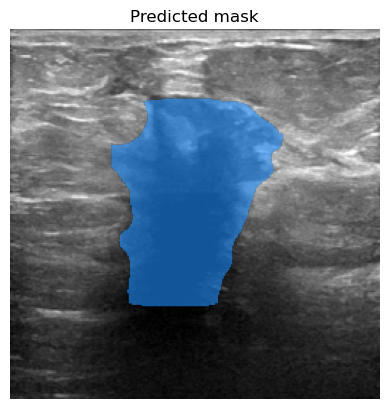

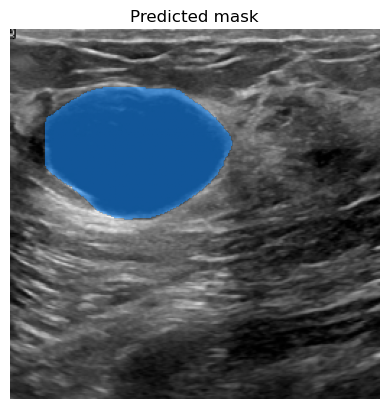

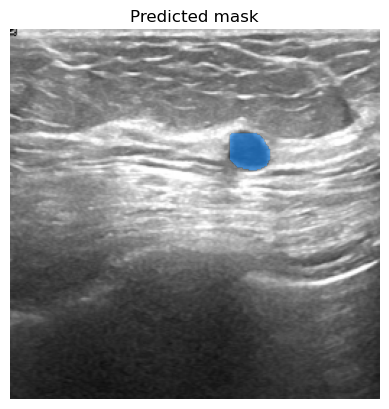

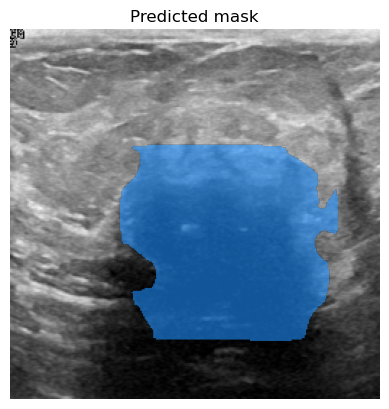

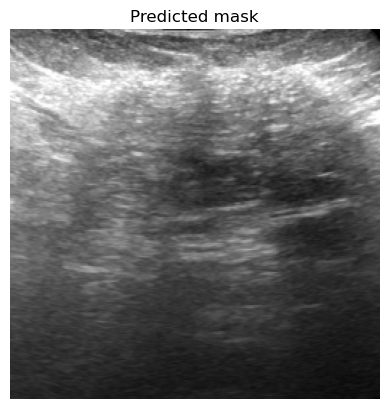

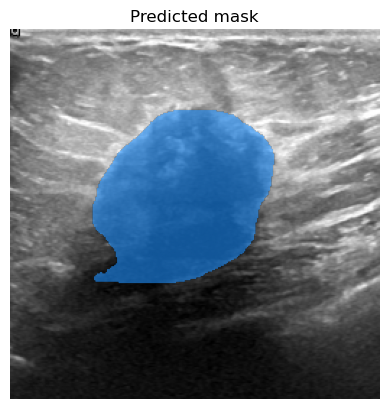

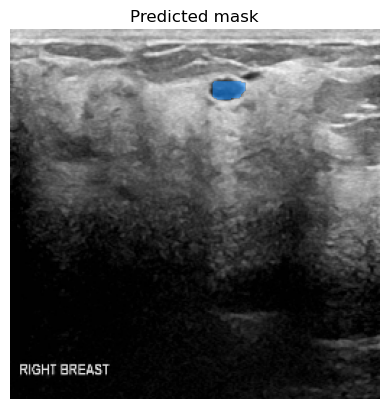

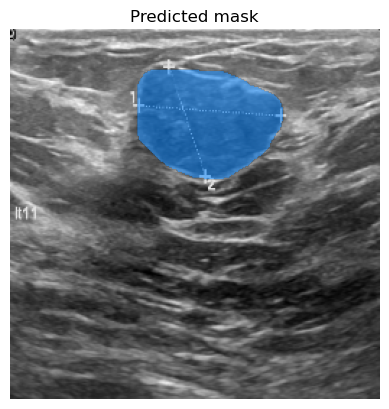

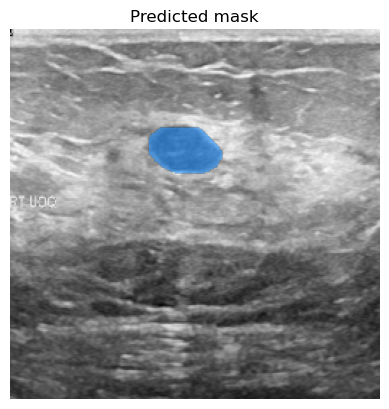

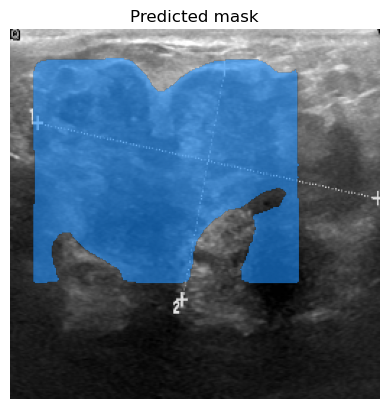

In [128]:
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(0)
ran_test=np.random.randint(518, size=10,dtype=np.dtype(int))

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
for i in ran_test:
    #print(i)
    results = model('datasets/Real_breast_cancer/test/images/'+str(i)+'.png',verbose=False)
    try:
        medsam_seg=results[0].masks.data.detach().cpu().numpy()[0]
        ground_truth_mask=np.asarray(Image.open('datasets/Real_breast_cancer_test_mask/'+str(i)+'.png'),dtype=np.uint8)
        dice = np.sum(medsam_seg[ground_truth_mask==1])*2.0 / (np.sum(medsam_seg) + np.sum(ground_truth_mask))
        iou = binaryMaskIOU(medsam_seg,ground_truth_mask)
    except:
        none_counter+=1
        medsam_seg=np.zeros((ground_truth_mask.shape[0],ground_truth_mask.shape[1]))
        dice=0
        iou=0
        pass
    image=Image.open('datasets/Real_breast_cancer/test/images/'+str(i)+'.png')

    fig, axes = plt.subplots()
    axes.imshow(np.array(image))
    show_mask(medsam_seg, axes)
    axes.title.set_text(f"Predicted mask")
    axes.axis("off")
    
    print(dice, iou)

## Test on Synthetic Breast Cancer Dataset 

In [107]:
import glob
import numpy as np
import re

IMAGE_SIZE=(256, 256)

def dataloader_test():
    t = glob.glob('archive/BUS Synthetic Dataset/BUS_synthetic_dataset/images/*')
    t_mask = glob.glob('archive/BUS Synthetic Dataset/BUS_synthetic_dataset/masks/*')
    t = sorted(t)
    t_mask = sorted(t_mask)
    print(len(t_mask))
    assert len(t)==len(t_mask)
    for i in range(len(t)):
        num1= int(t[i].split('.')[0].split('\\')[-1])
        num2= int(t_mask[i].split('.')[0].split('\\')[-1])
        #print(num1,num2)
        assert num1 == num2
    return t,t_mask

BUS_test,BUS_test_mask=dataloader_test()

500


In [108]:
for index,i in enumerate(BUS_test):
    img=Image.open(i).resize((256,256))
    img.save('datasets/Synthetic_breast_cancer/images/'+str(index)+'.png')
for index,i in enumerate(BUS_test_mask):
    img=Image.open(i).resize((256,256)).convert('1')
    img.save('datasets/Synthetic_breast_cancer/labels/'+str(index)+'.png')

In [132]:
dice_scores=[]
iou_scores=[]
none_counter=0

for i in range(1,500):
    #print(i)
    results = model('datasets/Synthetic_breast_cancer/images/'+str(i)+'.png',verbose=False)
    try:
        medsam_seg=results[0].masks.data.detach().cpu().numpy()[0]
        ground_truth_mask=np.asarray(Image.open('datasets/Synthetic_breast_cancer/labels/'+str(i)+'.png').convert('1'),dtype=np.uint8)
        dice = np.sum(medsam_seg[ground_truth_mask==1])*2.0 / (np.sum(medsam_seg) + np.sum(ground_truth_mask))
        dice_scores.append(dice)
        iou = binaryMaskIOU(medsam_seg,ground_truth_mask)
        iou_scores.append(iou)
    except Exception as e:
        none_counter+=1
        pass
np.average(dice_scores), np.average(iou_scores), map50(np.array(iou_scores)),none_counter

(0.7832754477348624, 0.6718349773737731, 0.7347515094613397, 11)

0.8892834760810528 0.8006394583411698
0.829624619546838 0.7088534442903375
0.843679405559808 0.7296241281322655
0.8576276187665978 0.7507426062249773
0.7974805269737475 0.6631747301079568
0.8777029422190713 0.7820593809222994
0.5795236791678072 0.4079784158797456
0.7819846910880263 0.6420154864773875
0.8247587142059504 0.7017782000814443
0.8031180400890868 0.6710085597320432


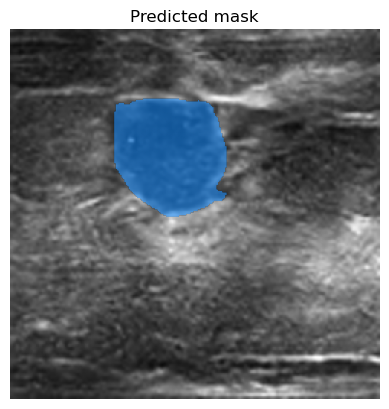

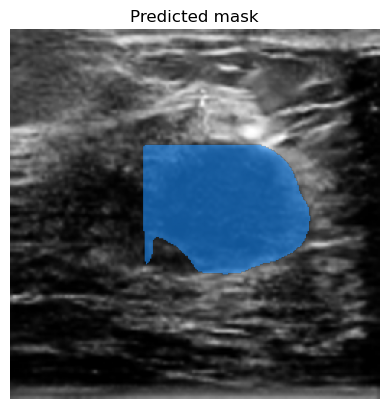

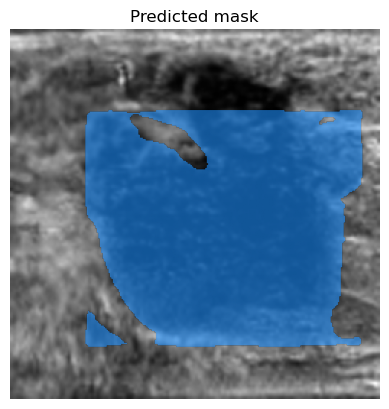

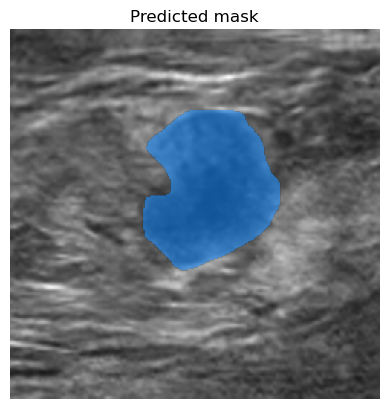

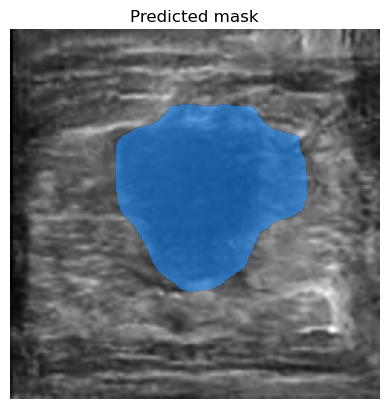

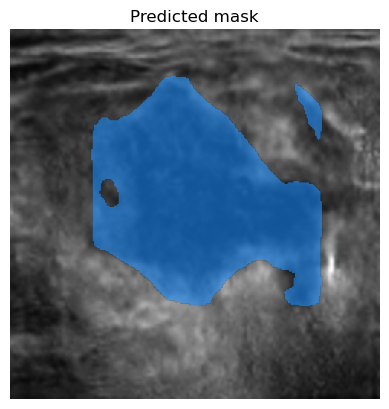

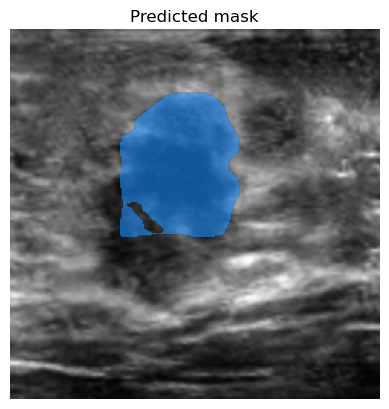

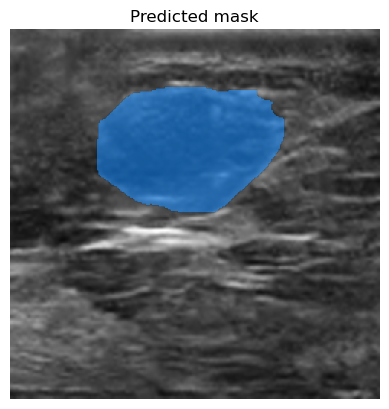

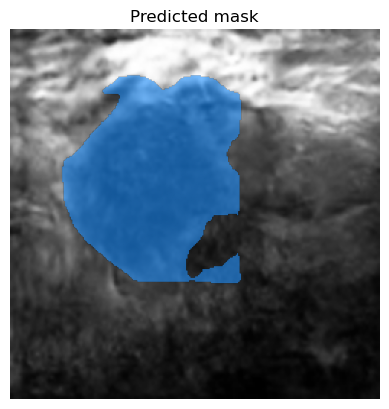

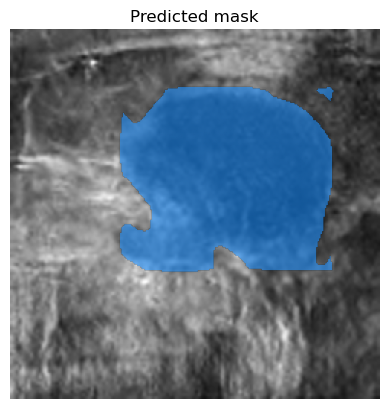

In [131]:
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(0)
ran_test=np.random.randint(500, size=10,dtype=np.dtype(int))

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
for i in ran_test:
    #print(i)
    results = model('datasets/Synthetic_breast_cancer/images/'+str(i)+'.png',verbose=False)
    try:
        medsam_seg=results[0].masks.data.detach().cpu().numpy()[0]
        ground_truth_mask=np.asarray(Image.open('datasets/Synthetic_breast_cancer/labels/'+str(i)+'.png'),dtype=np.uint8)
        dice = np.sum(medsam_seg[ground_truth_mask==1])*2.0 / (np.sum(medsam_seg) + np.sum(ground_truth_mask))
        iou = binaryMaskIOU(medsam_seg,ground_truth_mask)
    except:
        none_counter+=1
        medsam_seg=np.zeros((ground_truth_mask.shape[0],ground_truth_mask.shape[1]))
        dice=0
        iou=0
        pass
    image=Image.open('datasets/Synthetic_breast_cancer/images/'+str(i)+'.png')

    fig, axes = plt.subplots()
    axes.imshow(np.array(image))
    show_mask(medsam_seg, axes)
    axes.title.set_text(f"Predicted mask")
    axes.axis("off")
    
    print(dice, iou)